In [1]:
#!pip install -e ../../
from geobench_v2.datasets import GeoBenchNZCattle
from geobench_v2.datamodules import GeoBenchNZCattleDataModule

import geobench_v2


/dccstor/terratorch/users/rkie/gitco/terratorch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
"""Ugly proxy objects so parsing config file works with transforms.

    These are necessary since, for LightningCLI to instantiate arguments as
    objects from the config, they must have type annotations

    In TorchGeo, `transforms` is passed in **kwargs, so it has no type annotations!
    To get around that, we create these wrappers that have transforms type annotated.
    They create the transforms and forward all method and attribute calls to the
    original TorchGeo datamodule.

    Additionally, TorchGeo datasets pass the data to the transforms callable
    as a dict, and as a tensor.

    Albumentations expects this data not as a dict but as different key-value
    arguments, and as numpy. We handle that conversion here. 
"""
from collections.abc import Callable
from typing import Any
from functools import partial


import pdb
import numpy as np
from torch import Tensor
from torch.utils.data import default_collate
import kornia.augmentation as K
from kornia.augmentation._2d.geometric.base import GeometricAugmentationBase2D


from geobench_v2.datamodules import GeoBenchClassificationDataModule, GeoBenchSegmentationDataModule, GeoBenchObjectDetectionDataModule

from terratorch.datasets.transforms import kornia_augmentations_to_callable_with_dict

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torchgeo.datasets.utils import percentile_normalization, lazy_import
from matplotlib import patches


class GeoBenchV2ClassificationDataModule(GeoBenchClassificationDataModule):
    """Proxy object for using Classification DataModules defined by geobench_v2.

    Allows for transforms to be defined and passed using config files.
    The only reason this class exists is so that we can annotate the transforms argument with a type.
    This is required for lightningcli and config files.
    As such, all getattr and setattr will be redirected to the underlying class.
    """

    def __init__(
        self,
        cls: type[GeoBenchClassificationDataModule],
        img_size: int,
        band_order: list | dict,
        batch_size: int | None = None,
        num_workers: int = 0,
        train_augmentations: None | list[GeometricAugmentationBase2D, K.VideoSequential] | str = "default",
        eval_augmentations: None | list[GeometricAugmentationBase2D, K.VideoSequential] | str = "default",
        **kwargs: Any,
    ):
        """Constructor

        Args:
            cls (type[GeoBenchClassificationDataModule]): geobench_v2 Classification DataModule class to be instantiated
            batch_size (int | None, optional): batch_size. Defaults to None.
            num_workers (int, optional): num_workers. Defaults to 0.
            transforms (None | list[GeometricAugmentationBase2D, K.VideoSequential], optional): List of Albumentations Transforms.
                Should enc with ToTensorV2. Defaults to None.
            **kwargs (Any): Arguments passed to instantiate `cls`.
        """
        if isinstance(train_augmentations, str):
            assert train_augmentations in ["default", "multi_temporal_default"],"If train_augmentations is a string, it must be 'default' or 'multi_temporal_default'"
        if isinstance(eval_augmentations, str):
            assert eval_augmentations in ["default", "multi_temporal_default"],"If eval_augmentations is a string, it must be 'default' or 'multi_temporal_default'"

        kwargs["img_size"] = img_size
        kwargs["band_order"] = band_order

        if batch_size is not None:
            kwargs["batch_size"] = batch_size

        if not train_augmentations in [None, "default", "multi_temporal_default"]:
            kwargs["train_augmentations"] =kornia_augmentations_to_callable_with_dict(train_augmentations)
        else:
            kwargs["train_augmentations"] = train_augmentations
            
        if not eval_augmentations in [None, "default", "multi_temporal_default"]:
            kwargs["eval_augmentations"] =kornia_augmentations_to_callable_with_dict(eval_augmentations)
        else:
            kwargs["eval_augmentations"] = eval_augmentations
        
        if isinstance(band_order, list): #REMOVE THIS FOR FINAL VERSION, IF LIST ASSUME IT CONTAIN BANDS DIRECTLY
            if len(band_order) > 0:
                if isinstance(band_order[0], dict):
                    band_order_dict = {}
                    for modality in band_order:
                        band_order_dict.update(modality)
                    band_order = band_order_dict
                    kwargs["band_order"] = band_order

        self._proxy = cls(num_workers=num_workers, **kwargs)
        super().__init__(
            dataset_class = self._proxy.dataset_class, 
            img_size = img_size,
            band_order = band_order)

    @property
    def collate_fn(self):
        return self._proxy.collate_fn

    @collate_fn.setter
    def collate_fn(self, value):
        self._proxy.collate_fn = value

    def setup(self, stage: str):
        return self._proxy.setup(stage)

    def train_dataloader(self):
        return self._proxy.train_dataloader()

    def val_dataloader(self):
        return self._proxy.val_dataloader()

    def test_dataloader(self):
        return self._proxy.test_dataloader()

    def _valid_attribute(self, *args: str):
        return self._proxy._valid_attribute(args)


class GeoBenchV2ObjectDetectionDataModule(GeoBenchObjectDetectionDataModule):
    """Proxy object for using Object Detection DataModules defined by geobench_v2.

    Allows for transforms to be defined and passed using config files.
    The only reason this class exists is so that we can annotate the transforms argument with a type.
    This is required for lightningcli and config files.
    As such, all getattr and setattr will be redirected to the underlying class.
    """

    def __init__(
        self,
        cls: type[GeoBenchObjectDetectionDataModule],
        root: str,
        img_size: int,
        band_order: Any,
        categories: list,
        batch_size: int | None = None,
        eval_batch_size: int | None = None,
        num_workers: int = 0,
        train_augmentations: None | list[GeometricAugmentationBase2D, K.VideoSequential] | str = "default",
        eval_augmentations: None | list[GeometricAugmentationBase2D, K.VideoSequential] | str = "default",
        plot_indexes: list = [0,1,2],
        collate_fn: Callable = None,
        **kwargs: Any,
    ):
        """Constructor

        Args:
            cls (type[GeoBenchObjectDetectionDataModule]): geobench_v2 Object Detection DataModule class to be instantiated
            batch_size (int | None, optional): batch_size. Defaults to None.
            num_workers (int, optional): num_workers. Defaults to 0.
            transforms (None | list[GeometricAugmentationBase2D, K.VideoSequential], optional): List of Albumentations Transforms.
                Should enc with ToTensorV2. Defaults to None.
            **kwargs (Any): Arguments passed to instantiate `cls`.
        """
        if isinstance(train_augmentations, str):
            assert train_augmentations in ["default", "multi_temporal_default"],"If train_augmentations is a string, it must be 'default' or 'multi_temporal_default'"
        if isinstance(eval_augmentations, str):
            assert eval_augmentations in ["default", "multi_temporal_default"],"If eval_augmentations is a string, it must be 'default' or 'multi_temporal_default'"
        
        kwargs['root'] = root
        kwargs["img_size"] = img_size
        kwargs["band_order"] = band_order

        if batch_size is not None:
            kwargs["batch_size"] = batch_size
        if eval_batch_size is not None:
            kwargs["eval_batch_size"] = batch_size
        if not train_augmentations in [None, "default", "multi_temporal_default"]:
            kwargs["train_augmentations"] =kornia_augmentations_to_callable_with_dict(train_augmentations)
        else:
            kwargs["train_augmentations"] = train_augmentations
            
        if not eval_augmentations in [None, "default", "multi_temporal_default"]:
            kwargs["eval_augmentations"] =kornia_augmentations_to_callable_with_dict(eval_augmentations)
        else:
            kwargs["eval_augmentations"] = eval_augmentations
        
        if len(band_order) > 0:
            if isinstance(band_order[0], dict):
                band_order_dict = {}
                for modality in band_order:
                    band_order_dict.update(modality)
                band_order = band_order_dict
                kwargs["band_order"] = band_order

        self._proxy = cls(num_workers=num_workers, **kwargs)
        super().__init__(
            dataset_class = self._proxy.dataset_class, 
            img_size = img_size,
            band_order = band_order,
            batch_size = batch_size,
            eval_batch_size = eval_batch_size)  # dummy arg
        
        self.collate_fn = collate_fn
        self.plot_indexes = plot_indexes
        self.categories = categories

    @property
    def collate_fn(self):
        return self._proxy.collate_fn

    @collate_fn.setter
    def collate_fn(self, value):
        self._proxy.collate_fn = value

    @property
    def patch_size(self):
        return self._proxy.patch_size

    @property
    def length(self):
        return self._proxy.length

    def setup(self, stage: str):
        return self._proxy.setup(stage)

    def train_dataloader(self):
        return self._proxy.train_dataloader()

    def val_dataloader(self):
        return self._proxy.val_dataloader()

    def test_dataloader(self):
        return self._proxy.test_dataloader()

    def _valid_attribute(self, *args: str):
        return self._proxy._valid_attribute(args)
    
    def plot(
        self,
        sample: dict[str, Tensor],
        show_titles: bool = True,
        suptitle: str | None = None,
        show_feats: str | None = 'both',
        box_alpha: float = 0.7,
        mask_alpha: float = 0.7,
        confidence_score = 0.5
    ) -> Figure:
        """Plot a sample from the dataset.

        Args:
            sample: a sample returned by :meth:`__getitem__`
            suptitle: optional string to use as a suptitle
            show_titles: flag indicating whether to show titles above each panel
            show_feats: optional string to pick features to be shown: boxes, masks, both
            box_alpha: alpha value of box
            mask_alpha: alpha value of mask

        Returns:
            a matplotlib Figure with the rendered sample

        Raises:
            AssertionError: if ``show_feats`` argument is invalid
            DependencyNotFoundError: If plotting masks and scikit-image is not installed.

        .. versionadded:: 0.4
        """
        assert show_feats in {'boxes', 'masks', 'both'}

        image = sample['image']
        image = image.median(1).values if len(image.shape) == 4 else image
        # get indexes to plot 
        image = image[ self.plot_indexes, :, :]
        if image.mean() > 1:
            image = image / 10000
        
        image = percentile_normalization(image.permute(1, 2, 0).numpy())

        if show_feats != 'boxes':
            skimage = lazy_import('skimage')

        boxes = sample['boxes'].cpu().numpy()
        labels = sample['labels'].cpu().numpy()

        if 'masks' in sample:
            masks = [mask.squeeze().cpu().numpy() for mask in sample['masks']]

        n_gt = len(boxes)

        ncols = 1
        show_predictions = 'prediction_labels' in sample

        if show_predictions:
            show_pred_boxes = False
            show_pred_masks = False
            prediction_labels = sample['prediction_labels'].numpy()
            prediction_scores = sample['prediction_scores'].numpy()
            if 'prediction_boxes' in sample:
                prediction_boxes = sample['prediction_boxes'].numpy()
                show_pred_boxes = True
            if 'prediction_masks' in sample:
                prediction_masks = sample['prediction_masks'].numpy()
                show_pred_masks = True

            n_pred = len(prediction_labels)
            ncols += 1

        # Display image
        fig, axs = plt.subplots(ncols=ncols, squeeze=False, figsize=(ncols * 10, 13))
        axs[0, 0].imshow(image)
        axs[0, 0].axis('off')

        cm = plt.get_cmap('gist_rainbow')
        for i in range(n_gt):
            class_num = labels[i]
            color = cm(class_num / len(self.categories))

            # Add bounding boxes
            x1, y1, x2, y2 = boxes[i]
            if show_feats in {'boxes', 'both'}:
                r = patches.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    linewidth=2,
                    alpha=box_alpha,
                    linestyle='dashed',
                    edgecolor=color,
                    facecolor='none',
                )
                axs[0, 0].add_patch(r)

            # Add labels
            label = self.categories[class_num]
            caption = label
            axs[0, 0].text(
                x1, y1 - 8, caption, color='white', size=11, backgroundcolor='none'
            )

            # Add masks
            if show_feats in {'masks', 'both'} and 'masks' in sample:
                mask = masks[i]
                contours = skimage.measure.find_contours(mask, 0.5)
                for verts in contours:
                    verts = np.fliplr(verts)
                    p = patches.Polygon(
                        verts, facecolor=color, alpha=mask_alpha, edgecolor='white'
                    )
                    axs[0, 0].add_patch(p)

            if show_titles:
                axs[0, 0].set_title('Ground Truth')

        if show_predictions:
            axs[0, 1].imshow(image)
            axs[0, 1].axis('off')
            for i in range(n_pred):
                score = prediction_scores[i]
                if score < confidence_score:
                    continue

                class_num = prediction_labels[i]
                color = cm(class_num / len(self.categories))

                if show_pred_boxes:
                    # Add bounding boxes
                    x1, y1, x2, y2 = prediction_boxes[i]
                    r = patches.Rectangle(
                        (x1, y1),
                        x2 - x1,
                        y2 - y1,
                        linewidth=2,
                        alpha=box_alpha,
                        linestyle='dashed',
                        edgecolor=color,
                        facecolor='none',
                    )
                    axs[0, 1].add_patch(r)

                    # Add labels
                    label = self.categories[class_num]
                    caption = f'{label} {score:.3f}'
                    axs[0, 1].text(
                        x1,
                        y1 - 8,
                        caption,
                        color='white',
                        size=11,
                        backgroundcolor='none',
                    )

                # Add masks
                if show_pred_masks:

                    mask = prediction_masks[i][0]
                    contours = skimage.measure.find_contours(mask, 0.5)
                    for verts in contours:
                        verts = np.fliplr(verts)
                        p = patches.Polygon(
                            verts, facecolor=color, alpha=mask_alpha, edgecolor='white'
                        )
                        axs[0, 1].add_patch(p)

            if show_titles:
                axs[0, 1].set_title('Prediction')

        if suptitle is not None:
            plt.suptitle(suptitle)

        plt.tight_layout()

        return fig




class GeoBenchV2SegmentationDataModule(GeoBenchSegmentationDataModule):
    """Proxy object for using Segmentation DataModules defined by geobench_v2.

    Allows for transforms to be defined and passed using config files.
    The only reason this class exists is so that we can annotate the transforms argument with a type.
    This is required for lightningcli and config files.
    As such, all getattr and setattr will be redirected to the underlying class.
    """

    def __init__(
        self,
        cls: type[GeoBenchSegmentationDataModule],
        img_size: int,
        band_order: list,
        batch_size: int | None = None,
        num_workers: int = 0,
        train_augmentations: None | list[GeometricAugmentationBase2D, K.VideoSequential] | str = "default",
        eval_augmentations: None | list[GeometricAugmentationBase2D, K.VideoSequential] | str = "default",
        **kwargs: Any,
    ):
        """Constructor

        Args:
            cls (type[GeoDataModule]): geobench_v2 Segmentation DataModule class to be instantiated
            batch_size (int | None, optional): batch_size. Defaults to None.
            num_workers (int, optional): num_workers. Defaults to 0.
            transforms (None | list[GeometricAugmentationBase2D, K.VideoSequential], optional): List of Kornia Transforms.
                Should enc with ToTensorV2. Defaults to None.
            **kwargs (Any): Arguments passed to instantiate `cls`.
        """
        if isinstance(train_augmentations, str):
            assert train_augmentations in ["default", "multi_temporal_default"],"If train_augmentations is a string, it must be 'default' or 'multi_temporal_default'"
        if isinstance(eval_augmentations, str):
            assert eval_augmentations in ["default", "multi_temporal_default"],"If eval_augmentations is a string, it must be 'default' or 'multi_temporal_default'"
            
        kwargs["img_size"] = img_size
        kwargs["band_order"] = band_order
        
        if batch_size is not None:
            kwargs["batch_size"] = batch_size

        if not train_augmentations in [None, "default", "multi_temporal_default"]:
            kwargs["train_augmentations"] = kornia_augmentations_to_callable_with_dict(train_augmentations)
        else:
            kwargs["train_augmentations"] = train_augmentations
            
        if not eval_augmentations in [None, "default", "multi_temporal_default"]:
            kwargs["eval_augmentations"] = kornia_augmentations_to_callable_with_dict(eval_augmentations)
        else:
            kwargs["eval_augmentations"] = eval_augmentations

        if len(band_order) > 0:
            print(f"\n\nband_order before: {band_order}")
            if isinstance(band_order[0], dict):
                band_order_dict = {}
                for modality in band_order:
                    band_order_dict.update(modality)
                band_order = band_order_dict
                kwargs["band_order"] = band_order

        self._proxy = cls(num_workers=num_workers, **kwargs)

        super().__init__(
            dataset_class = self._proxy.dataset_class, 
            img_size = img_size,
            band_order = band_order
            )  # dummy arg

    @property
    def collate_fn(self):
        return self._proxy.collate_fn

    @collate_fn.setter
    def collate_fn(self, value):
        self._proxy.collate_fn = value

    @property
    def patch_size(self):
        return self._proxy.patch_size

    @property
    def length(self):
        return self._proxy.length

    @property
    def val_dataset(self):
        return self._proxy.val_dataset

    def setup(self, stage: str):
        return self._proxy.setup(stage)

    def train_dataloader(self):
        return self._proxy.train_dataloader()

    def val_dataloader(self):
        return self._proxy.val_dataloader()

    def test_dataloader(self):
        return self._proxy.test_dataloader()

    def _valid_attribute(self, *args: str):
        return self._proxy._valid_attribute(args)







            

In [12]:
dm = GeoBenchV2ObjectDetectionDataModule(cls=geobench_v2.datamodules.GeoBenchNZCattleDataModule,
                                num_workers=32,
                                img_size=512,
                                root='.',
                                band_order=['RED','GREEN','BLUE'],
                                collate_fn=geobench_v2.datamodules.nzcattle.nzcattle_collate_fn,
                                categories=['Background','Cattle'],
                                plot_indexes=[0,1,2],
                            )


In [13]:
# modified from https://torchgeo.readthedocs.io/en/latest/_modules/torchgeo/trainers/detection.html#ObjectDetectionTask
# and from https://torchgeo.readthedocs.io/en/latest/_modules/torchgeo/trainers/instance_segmentation.html#InstanceSegmentationTask

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

"""Trainers for object detection."""

from typing import Any

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torch import Tensor
from torchmetrics import MetricCollection
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from torchgeo.datasets import RGBBandsMissingError, unbind_samples
from torchgeo.trainers import BaseTask

from terratorch.registry import MODEL_FACTORY_REGISTRY
from terratorch.tasks.loss_handler import LossHandler
from terratorch.tasks.optimizer_factory import optimizer_factory
import pdb
import torch
import warnings
from torchvision.ops import nms


def get_batch_size(x):
    if isinstance(x, torch.Tensor):
        batch_size = x.shape[0]
    elif isinstance(x, dict):
        batch_size = list(x.values())[0].shape[0]
    else:
        raise ValueError(f"Expect x to be torch.Tensor or dict, got {type(x)}")
    return batch_size


class ObjectDetectionTask(BaseTask):

    ignore = None
    monitor = 'val_map'
    mode = 'max'

    def __init__(
        self,
        model_factory: str,
        model_args: dict,

        lr: float = 0.001,

        optimizer: str | None = None,
        optimizer_hparams: dict | None = None,
        scheduler: str | None = None,
        scheduler_hparams: dict | None = None,

        freeze_backbone: bool = False,
        freeze_decoder: bool = False,
        class_names: list[str] | None = None,

        iou_threshold: float = 0.5,
        score_threshold: float = 0.5,
        
        boxes_field: str = 'boxes',
        labels_field: str = 'labels',
        masks_field: str = 'masks',

    ) -> None:
       
        """
        Initialize a new ObjectDetectionTask instance.

        Args:
            model_factory (str): Name of the model factory to use.
            model_args (dict): Arguments for the model factory.
            lr (float, optional): Learning rate for optimizer. Defaults to 0.001.
            optimizer (str | None, optional): Name of the optimizer to use. Defaults to None.
            optimizer_hparams (dict | None, optional): Hyperparameters for the optimizer. Defaults to None.
            scheduler (str | None, optional): Name of the scheduler to use. Defaults to None.
            scheduler_hparams (dict | None, optional): Hyperparameters for the scheduler. Defaults to None.
            freeze_backbone (bool, optional): Freeze the backbone network to fine-tune the detection head. Defaults to False.
            freeze_decoder (bool, optional): Freeze the decoder network to fine-tune the detection head. Defaults to False.
            class_names (list[str] | None, optional): List of class names. Defaults to None.
            iou_threshold (float, optional): Intersection over union threshold for evaluation. Defaults to 0.5.
            score_threshold (float, optional): Score threshold for evaluation. Defaults to 0.5.
            boxes_field (str): The field containing the bbox information in the sample. Deafult is boxes
            labels_field (str): The field containing the labels information in the sample. Deafult is labels
            masks_field (str): The field containing the masks information in the sample. Deafult is masks

        Returns:
            None
        """
        warnings.warn("The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.")
        
        self.model_factory = MODEL_FACTORY_REGISTRY.build(model_factory)
        self.framework = model_args['framework']
        self.monitor = 'val_segm_map' if self.framework == 'mask-rcnn' else self.monitor
        
        super().__init__()
        self.train_loss_handler = LossHandler(self.train_metrics.prefix)
        self.test_loss_handler = LossHandler(self.test_metrics.prefix)
        self.val_loss_handler = LossHandler(self.val_metrics.prefix)
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        self.lr = lr
        if optimizer_hparams is not None:
            if "lr" in self.hparams["optimizer_hparams"].keys():
                self.lr = float(self.hparams["optimizer_hparams"]["lr"])
                del self.hparams["optimizer_hparams"]["lr"]
                
        self.boxes_field = boxes_field
        self.labels_field = labels_field
        self.masks_field = masks_field

    def configure_models(self) -> None:
        """
        It instantiates the model and freezes/unfreezes the backbone and decoder networks.
        """

        self.model: Model = self.model_factory.build_model(
            "object_detection", **self.hparams["model_args"]
        )
        if self.hparams["freeze_backbone"]:
            self.model.freeze_encoder()
        if self.hparams["freeze_decoder"]:
            self.model.freeze_decoder()

    def configure_metrics(self) -> None:
        """
        Configure metrics for the task.
        """
        if self.framework == 'mask-rcnn':
            metrics = MetricCollection({
                "mAP": MeanAveragePrecision(
                    iou_type=('bbox', 'segm'),
                    average='macro'
                )
            })
        else:
            metrics = MetricCollection({
                "mAP": MeanAveragePrecision(
                    iou_type=('bbox'),
                    average='macro'
                )
            })

        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def configure_optimizers(
        self,
    ) -> "lightning.pytorch.utilities.types.OptimizerLRSchedulerConfig":
        """
        Configure optimiser for the task.
        """
        optimizer = self.hparams["optimizer"]
        if optimizer is None:
            optimizer = "Adam"
        return optimizer_factory(
            optimizer,
            self.lr,
            self.parameters(),
            self.hparams["optimizer_hparams"],
            self.hparams["scheduler"],
            self.monitor,
            self.hparams["scheduler_hparams"],
        )

    def reformat_batch(self, batch: Any, batch_size: int):
        """
        Reformat batch to calculate loss and metrics.

        Args:
            batch: The output of your DataLoader.
            batch_size: Size of your batch
        Returns:
            Reformated batch
        """

        if (('masks' in batch.keys()) | ('mask' in batch.keys()) | (self.masks_field in batch.keys())):
            y = [
                {'boxes': batch[self.boxes_field][i], 'labels': batch[self.labels_field][i], 'masks': torch.cat([x[None].to(torch.uint8) for x in batch[self.masks_field][i]])}
                for i in range(batch_size)
            ]
        else:

            y = [
                {'boxes': batch[self.boxes_field][i], 'labels': batch[self.labels_field][i]}
                for i in range(batch_size)
            ]

        return y

    def apply_nms_sample(self, y_hat, iou_threshold=0.5, score_threshold=0.5):
        """
        It applies nms to a sample predictions of the model.

        Args:
            y_hat: Predictions dictionary.
            iou_threshold: IoU threshold for evaluation.
            score_threshold: Score threshold for evaluation.
        Returns:
            fintered predictions for a sample after applying nms batch
        """

        boxes, scores, labels = y_hat['boxes'], y_hat['scores'], y_hat['labels']
        masks = y_hat['masks'] if "masks" in y_hat.keys() else None

        # Filter based on score threshold
        keep_score = scores > score_threshold
        boxes, scores, labels = boxes[keep_score], scores[keep_score], labels[keep_score]
        if masks is not None:
            masks = masks[keep_score]

        # Apply NMS
        keep_nms = nms(boxes, scores, iou_threshold)

        y_hat['boxes'], y_hat['scores'], y_hat['labels'] = boxes[keep_nms], scores[keep_nms], labels[keep_nms]

        if masks is not None:
            y_hat['masks'] = masks[keep_nms]

        return y_hat

    def apply_nms_batch(self, y_hat: Any, batch_size: int):
        """
        It applies nms to a batch predictions of the model.

        Args:
            y_hat: List of predictions dictionaries.
            iou_threshold: IoU threshold for evaluation.
            score_threshold: Score threshold for evaluation.
        Returns:
            fintered predictions for a batch after applying nms batch
        """

        for i in range(batch_size):
            y_hat[i] = self.apply_nms_sample(y_hat[i], iou_threshold=self.iou_threshold, score_threshold=self.score_threshold)

        return y_hat

    def training_step(
        self, batch: Any, batch_idx: int, dataloader_idx: int = 0
    ) -> Tensor:
        """
        Compute the training loss.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.

        Returns:
            The loss dictionary.
        """

        x = batch['image']
        batch_size = get_batch_size(x)
        y = self.reformat_batch(batch, batch_size)
        loss_dict = self(x, y)
        if isinstance(loss_dict, dict) is False:
            loss_dict = loss_dict.output
        train_loss: Tensor = sum(loss_dict.values())
        self.log_dict(loss_dict, batch_size=batch_size)
        self.log("train_loss", train_loss)
        return train_loss

    def validation_step(
        self, batch: Any, batch_idx: int, dataloader_idx: int = 0
    ) -> None:
        """
        Compute the validation metrics.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.
        """
        
        x = batch['image']
        batch_size = get_batch_size(x)
        y = self.reformat_batch(batch, batch_size)
        y_hat = self(x)
        if isinstance(y_hat, dict) is False:
            y_hat = y_hat.output
    
        y_hat = self.apply_nms_batch(y_hat, batch_size)

        if self.framework == 'mask-rcnn':

            for i in range(len(y_hat)):
                if y_hat[i]['masks'].shape[0] > 0:

                    y_hat[i]['masks']= (y_hat[i]['masks'] > 0.5).squeeze(1).to(torch.uint8)

        metrics = self.val_metrics(y_hat, y) 

        # https://github.com/Lightning-AI/torchmetrics/pull/1832#issuecomment-1623890714
        metrics.pop('val_classes', None)


        self.log_dict(metrics, batch_size=batch_size)
        
        if (
            batch_idx < 10
            and hasattr(self.trainer, 'datamodule')
            and hasattr(self.trainer.datamodule, 'plot')
            and self.logger
            and hasattr(self.logger, 'experiment')
            and (hasattr(self.logger.experiment, 'add_figure') | hasattr(self.logger.experiment, 'log_figure'))
        ):

            if 'boxes' not in batch.keys():
                batch['boxes'] = batch.pop(self.boxes_field)
            if 'labels' not in batch.keys():
                batch['labels'] = batch.pop(self.labels_field)
            if self.framework == 'mask-rcnn':
                if 'masks' not in batch.keys():
                    batch['masks'] = batch.pop(self.masks_field)

            # dataset = self.trainer.datamodule.val_dataset
            batch['prediction_boxes'] = [b['boxes'].cpu() for b in y_hat]
            batch['prediction_labels'] = [b['labels'].cpu() for b in y_hat]
            batch['prediction_scores'] = [b['scores'].cpu() for b in y_hat]

            if "masks" in y_hat[0].keys():
                batch['prediction_masks'] = [b['masks'].cpu() for b in y_hat]
                if self.framework == 'mask-rcnn':
                    batch['prediction_masks'] = [b.unsqueeze(1) for b in batch['prediction_masks']]

            batch['image'] = batch['image'].cpu()
            sample = unbind_samples(batch)[0]
            fig: Figure | None = None
            try:
                if hasattr(self.trainer.datamodule, 'val_dataset'):
                    if (hasattr(self.trainer.datamodule.val_dataset, 'plot') and hasattr(self.trainer.datamodule.val_dataset, 'plot')):
                        fig = self.trainer.datamodule.val_dataset.plot(sample)
                    elif hasattr(self.trainer.datamodule, 'plot') and callable(getattr(self.trainer.datamodule, 'plot')):
                        fig = self.trainer.datamodule.plot(sample)
                elif hasattr(self.trainer.datamodule, 'plot') and callable(getattr(self.trainer.datamodule, 'plot')):
                    fig = self.trainer.datamodule.plot(sample)

            except RGBBandsMissingError:
                pass

            if fig:
                # pdb.set_trace()
                summary_writer = self.logger.experiment
                if hasattr(self.logger.experiment, 'add_figure'):
                    summary_writer.add_figure(
                        f'image/{batch_idx}', fig, global_step=self.global_step
                    )
                elif hasattr(self.logger.experiment, 'log_figure'):
                    summary_writer.log_figure(
                        self.logger.run_id, fig, f"epoch_{self.current_epoch}_{batch_idx}.png"
                    )
                plt.close()

    def test_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> None:
        """
        Compute the test metrics.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.
        """

        x = batch['image']
        batch_size = get_batch_size(x)
        y = self.reformat_batch(batch, batch_size)
        y_hat = self(x)
        if isinstance(y_hat, dict) is False:
            y_hat = y_hat.output

        y_hat = self.apply_nms_batch(y_hat, batch_size)

        if self.framework == 'mask-rcnn':

            for i in range(len(y_hat)):
                if y_hat[i]['masks'].shape[0] > 0:
                    y_hat[i]['masks']= (y_hat[i]['masks'] > 0.5).squeeze(1).to(torch.uint8)


        metrics = self.test_metrics(y_hat, y)

        # https://github.com/Lightning-AI/torchmetrics/pull/1832#issuecomment-1623890714
        metrics.pop('test_classes', None)

        self.log_dict(metrics, batch_size=batch_size)

    def predict_step(
        self, batch: Any, batch_idx: int, dataloader_idx: int = 0
    ) -> list[dict[str, Tensor]]:
        """
        Output predicted bounding boxes, classes and masks.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.

        Returns:
            Output predicted bounding boxes, classes and masks.
        """
        x = batch['image']
        batch_size = get_batch_size(x)
        y_hat: list[dict[str, Tensor]] = self(x)
        if isinstance(y_hat, dict) is False:
            y_hat = y_hat.output

        y_hat = self.apply_nms_batch(y_hat, batch_size)

        return y_hat

In [14]:
model_args = {
    "framework": "faster-rcnn",
    "backbone": "terramind_v1_tiny",
    "backbone_pretrained": True,
    "num_classes": 2,
    "framework_min_size": 512,
    "framework_max_size": 512,
    "backbone_modalities": ["RGB"],
    "in_channels": 3,
    "necks": [
        {
            "name": "SelectIndices",
            "indices": [2, 5, 8, 11]
        },
        {
            "name": "ReshapeTokensToImage",
            "remove_cls_token": False
        },
        {
            "name": "LearnedInterpolateToPyramidal"
        },
        {
            "name": "FeaturePyramidNetworkNeck"
        }
    ]
}
task = ObjectDetectionTask(model_factory='ObjectDetectionModelFactory', 
    model_args=model_args,
    freeze_backbone=False,
    freeze_decoder=False,
    class_names=['Background','Cattle'],
    boxes_field='bbox_xyxy',
    labels_field='label',
)

/tmp/ipykernel_3102819/841259444.py:93: UserWarning: The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.
  warnings.warn("The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.")


In [15]:
import os
os.environ["HF_TOKEN"] = ""


In [16]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
import torch

checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints",
    filename="odet-{epoch:02d}-{val_loss:.2f}",
    save_last=True,
)

In [17]:
#task = ObjectDetectionTask.load_from_checkpoint("./checkpoints/last-v9.ckpt")

In [18]:
trainer = Trainer(
    devices='auto',
    accelerator="auto",
    strategy='auto',
    max_epochs=50,
    num_nodes=1,
    precision='16-mixed',
    default_root_dir='output',
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    callbacks=[checkpoint_cb, LearningRateMonitor(logging_interval='epoch')],
    logger=True,

)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
2025-08-22 09:50:07,386 - INFO - Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
2025-08-22 09:50:12,153 - INFO - GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
2025-08-22 09:50:12,155 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-08-22 09:50:12,155 - INFO - HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model=task, datamodule=dm)  

/dccstor/terratorch/users/rkie/gitco/terratorch/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /dccstor/terratorch/users/rkie/gitco/terratorch/examples/notebooks/checkpoints exists and is not empty.
INFO: 
  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | model         | ObjectDetectionModel | 22.6 M | train
1 | train_metrics | MetricCollection     | 0      | train
2 | val_metrics   | MetricCollection     | 0      | train
3 | test_metrics  | MetricCollection     | 0      | train
---------------------------------------------------------------
22.6 M    Trainable params
0         Non-trainable params
22.6 M    Total params
90.577    Total estimated model params size (MB)
236       Modules in train mode
0         Modules in eval mode
2025-08-22 09:50:12,805 - INFO - 
  | Name          | Type                 | Params | Mode 
-----------------------------

Initializing normalizer from class: ZScoreNormalizer
Initializing normalizer from class: ZScoreNormalizer
Sanity Checking DataLoader 0:   0%|                                                                                                                                   | 0/2 [00:00<?, ?it/s]

TypeError: Got unsupported ScalarType BFloat16

In [20]:
from terratorch.models.object_detection_model_factory import ModelOutputObjectDetection
import torch
from torch import Tensor

class ONNXWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        out = self.model(*args, **kwargs)

        # --- Handle ModelOutputObjectDetection ---
        if isinstance(out, ModelOutputObjectDetection):
            if isinstance(out.output, dict):
                # Single image
                boxes = out.output.get("boxes", torch.empty(0, 4))
                scores = out.output.get("scores", torch.empty(0))
                labels = out.output.get("labels", torch.empty(0, dtype=torch.long))
                return boxes, scores, labels

            elif isinstance(out.output, list):
                # Batch: flatten all boxes/scores/labels into single tensors
                all_boxes, all_scores, all_labels = [], [], []
                for item in out.output:
                    all_boxes.append(item.get("boxes", torch.empty(0, 4)))
                    all_scores.append(item.get("scores", torch.empty(0)))
                    all_labels.append(item.get("labels", torch.empty(0, dtype=torch.long)))

                boxes = torch.cat(all_boxes, dim=0) if all_boxes else torch.empty(0, 4)
                scores = torch.cat(all_scores, dim=0) if all_scores else torch.empty(0)
                labels = torch.cat(all_labels, dim=0) if all_labels else torch.empty(0, dtype=torch.long)
                return boxes, scores, labels

        # --- If it's already a tensor ---
        if isinstance(out, Tensor):
            return out

        # --- Fallback ---
        raise TypeError(f"Unsupported model output type: {type(out)}")



In [69]:
import torchvision.ops as ops

class ONNXWrapperWithNMS(torch.nn.Module):
    def __init__(self, model, iou_thresh=0.5, score_thresh=0.05):
        super().__init__()
        self.model = model
        self.iou_thresh = iou_thresh
        self.score_thresh = score_thresh

    def forward(self, x):
        boxes, scores, labels = ONNXWrapper(self.model)(x)
        keep = scores > self.score_thresh
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]
        keep_nms = ops.nms(boxes, scores, self.iou_thresh)
        return boxes[keep_nms], scores[keep_nms], labels[keep_nms]


In [63]:
model = ObjectDetectionTask.load_from_checkpoint("./checkpoints/last.ckpt")

/tmp/ipykernel_3102819/841259444.py:93: UserWarning: The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.
  warnings.warn("The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.")


In [64]:
model.eval()

ObjectDetectionTask(
  (model): ObjectDetectionModel(
    (torchvision_model): FasterRCNN(
      (transform): GeneralizedRCNNTransform(
          Normalize(mean=[0 0 0], std=[1 1 1])
          Resize(min_size=(512,), max_size=512, mode='bilinear')
      )
      (backbone): BackboneWrapper(
        (backbone): TerraMindViT(
          (encoder_embeddings): ModuleDict(
            (untok_sen2rgb@224): ImageEncoderEmbedding(
              (proj): Linear(in_features=768, out_features=192, bias=False)
            )
          )
          (encoder): ModuleList(
            (0-11): 12 x Block(
              (norm1): LayerNorm()
              (attn): Attention(
                (qkv): Linear(in_features=192, out_features=576, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=192, out_features=192, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
              (

In [70]:
onnx_model = ONNXWrapperWithNMS(model)

In [71]:
onnx_model.eval()


ONNXWrapperWithNMS(
  (model): ObjectDetectionTask(
    (model): ObjectDetectionModel(
      (torchvision_model): FasterRCNN(
        (transform): GeneralizedRCNNTransform(
            Normalize(mean=[0 0 0], std=[1 1 1])
            Resize(min_size=(512,), max_size=512, mode='bilinear')
        )
        (backbone): BackboneWrapper(
          (backbone): TerraMindViT(
            (encoder_embeddings): ModuleDict(
              (untok_sen2rgb@224): ImageEncoderEmbedding(
                (proj): Linear(in_features=768, out_features=192, bias=False)
              )
            )
            (encoder): ModuleList(
              (0-11): 12 x Block(
                (norm1): LayerNorm()
                (attn): Attention(
                  (qkv): Linear(in_features=192, out_features=576, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=192, out_features=192, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=Fal

In [72]:
dummy_input = torch.randn(1, 3, 512,512)  # batch size 1, 10 features
torch.onnx.export(
    onnx_model,              # the PyTorch model
    dummy_input,              # dummy input
    "model_tm_tiny_nzcattle.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['boxes', 'scores', 'labels'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'boxes': {0: 'num_boxes'},
        'scores': {0: 'num_boxes'},
        'labels': {0: 'num_boxes'}
    }
)


In [73]:
torch.onnx.export(
    onnx_model,              # the PyTorch model
    dummy_input,              # dummy input
    "model_tm_tiny_nzcattle.onnx",             # output file     
    export_params=True,       # store trained weights
    opset_version=17,         # recommended ONNX opset
    do_constant_folding=True, # optimize constants
    input_names=['input'],    # model input name
    output_names=['output'],  # model output name
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # allow variable batch size
)

/tmp/ipykernel_3102819/2600707016.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [97]:
result = onnx_model(dummy_input)

In [103]:
result[1]

tensor([0.9386, 0.9076, 0.8965, 0.8828, 0.8724, 0.8657, 0.8643, 0.8550, 0.8455,
        0.8367, 0.8293, 0.8283, 0.8224, 0.8174, 0.8100, 0.8081, 0.8018, 0.7894,
        0.7837, 0.7783, 0.7726, 0.7602, 0.7546, 0.7446, 0.7367, 0.7354, 0.7351,
        0.7311, 0.7298, 0.7293, 0.7213, 0.7156, 0.7114, 0.7036, 0.7013, 0.6991,
        0.6971, 0.6922, 0.6881, 0.6877, 0.6548, 0.6507, 0.6506, 0.6336, 0.6315,
        0.6291, 0.6291, 0.6272, 0.6211, 0.6201, 0.6081, 0.6022, 0.6018, 0.5970,
        0.5910, 0.5870, 0.5860, 0.5800, 0.5787, 0.5783, 0.5779, 0.5671, 0.5608,
        0.5591, 0.5581, 0.5546, 0.5490, 0.5477, 0.5469, 0.5445, 0.5319, 0.5240,
        0.5194, 0.5100, 0.5089, 0.5083, 0.5020, 0.4924, 0.4924, 0.4905, 0.4905,
        0.4823, 0.4810, 0.4752, 0.4720, 0.4715, 0.4682, 0.4477, 0.4453, 0.4411,
        0.4395, 0.4280, 0.4276, 0.4221, 0.4165, 0.4131, 0.4121, 0.4090, 0.4085,
        0.4068], grad_fn=<IndexBackward0>)

In [29]:
dm.setup(stage='test')

Initializing normalizer from class: ZScoreNormalizer


In [30]:
dl = dm.test_dataloader()

In [31]:
example = next(iter(dl))

In [75]:
prediction = onnx_model(example['image'])

In [81]:
prediction[1][0]

tensor(0.9882, grad_fn=<SelectBackward0>)

In [109]:
import numpy as np
import onnxruntime as ort

# Assuming 'session' is an existing ONNX Runtime InferenceSession object
# session = ort.InferenceSession("path/to/your/model.onnx")

input_name = session.get_inputs()[0].name
input_shape = (1, 3, 512, 512)

# Generate a random NumPy array with the correct shape and data type
# You may need to change the dtype depending on your model's input
random_input = np.random.rand(*input_shape).astype(np.float32)

# Run the inference session with the input data
result  =session.run(None, {input_name: random_input})

In [116]:
result[0]

array([[ 40.64887  , 106.74319  ,  53.80952  , 120.55137  ],
       [132.97339  , 234.41937  , 145.08524  , 248.02066  ],
       [122.34826  , 385.8149   , 135.90353  , 399.44644  ],
       [331.12485  , 227.36052  , 344.39072  , 240.86974  ],
       [328.2447   , 349.3918   , 340.646    , 362.368    ],
       [440.12918  , 482.44736  , 453.30386  , 495.98465  ],
       [219.78285  , 195.28383  , 233.03297  , 209.22496  ],
       [470.9771   ,  58.479248 , 483.0061   ,  71.99809  ],
       [469.53696  , 190.55968  , 481.6669   , 203.85567  ],
       [264.08856  , 245.48488  , 276.67883  , 258.90872  ],
       [153.33633  , 205.56386  , 166.08127  , 219.00801  ],
       [338.7806   , 191.36438  , 350.8309   , 204.47961  ],
       [458.92514  , 256.14865  , 472.11575  , 271.05527  ],
       [220.60886  , 199.70213  , 234.26001  , 213.31343  ],
       [279.54974  , 124.50263  , 292.75903  , 137.64803  ],
       [407.31226  , 127.25229  , 420.25195  , 140.78293  ],
       [ 42.063744 , 386

In [88]:
import onnxruntime as ort
import torch
import numpy as np
import torchvision.ops as ops
from PIL import Image

def run_onnx_od(image: np.ndarray, session: ort.InferenceSession, score_thresh=0.05, iou_thresh=0.5):
    """
    Run ONNX object detection model with NMS.

    Args:
        image: HxWx3 numpy array, float32, scaled like training (0-1).
        session: onnxruntime.InferenceSession object.
        score_thresh: min score to keep a box.
        iou_thresh: IoU threshold for NMS.

    Returns:
        boxes, scores, labels: torch tensors after NMS.
    """
    # ONNX expects shape: 1xCxHxW
    input_name = session.get_inputs()[0].name
    x = np.transpose(image, (2, 0, 1))[None, ...].astype(np.float32)  # HWC -> NCHW

    # Run inference
    outputs = session.run(None, {input_name: x})
    boxes, scores, labels = [torch.from_numpy(o) for o in outputs]

    # Filter by score threshold
    keep = scores > score_thresh
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    # Apply NMS
    keep_nms = ops.nms(boxes, scores, iou_thresh)
    boxes, scores, labels = boxes[keep_nms], scores[keep_nms], labels[keep_nms]

    return boxes, scores, labels

# --- Example usage ---
# Load ONNX model
session = ort.InferenceSession("model_tm_tiny_nzcattle.onnx")




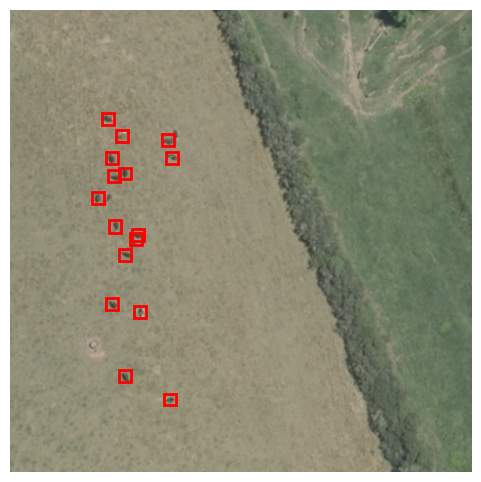

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img = example['image'][0].permute(1, 2, 0).cpu().numpy()


boxes, scores, labels = run_onnx_od(img, session, score_thresh=0.7, iou_thresh=0.5)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)
#prediction = onnx_model(example['image'])


# Draw each box
for box in boxes:
    xmin, ymin, xmax, ymax = box.tolist()
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle(
        (xmin, ymin), width, height,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()
